In [1]:

!pip install streamlit
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyngrok import ngrok
import os

In [3]:


# URL du fichier CSV
url = "https://object.files.data.gouv.fr/data-pipeline-open/prod/elections/general_results.csv"

try:
    # Télécharger le fichier
    response = requests.get(url)
    response.raise_for_status()

    # Charger dans un DataFrame avec gestion des erreurs
    print("Téléchargement des données et chargement dans un DataFrame...")
    df = pd.read_csv(io.StringIO(response.content.decode('utf-8', errors='replace')), sep=',', low_memory=False, on_bad_lines='skip')


except requests.exceptions.RequestException as e:
    print(f"Une erreur est survenue lors du téléchargement : {e}")
except pd.errors.ParserError as e:
    print(f"Une erreur est survenue lors du parsing : {e}")


Téléchargement des données et chargement dans un DataFrame...


In [4]:
df_corrected = df.iloc[:, 0].str.split(';', expand=True)

In [5]:
# Liste des noms de colonnes à ajouter
noms_colonnes = [
    'id_election', 'id_brut_miom', 'Code du département', 'Libellé du département',
    'Code de la commune', 'Libellé de la commune', 'Code du b.vote', 'Inscrits',
    'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins', 'Blancs', '% Blancs/Ins',
    '% Blancs/Vot', 'Nuls', '% Nuls/Ins', '% Nuls/Vot', 'Exprimés', '% Exp/Ins',
    '% Exp/Vot', 'Code de la circonscription', 'Libellé de la circonscription',
    'Code du canton', 'Libellé du canton'
]

# Ajouter les noms des colonnes au DataFrame corrigé
df_corrected.columns = noms_colonnes

In [6]:
# Afficher toutes les colonnes
pd.set_option('display.max_columns', None)

# Afficher les premières lignes du DataFrame
df_corrected.head()

,id_election,id_brut_miom,Code du département,Libellé du département,Code de la commune,Libellé de la commune,Code du b.vote,Inscrits,Abstentions,% Abs/Ins,Votants,% Vot/Ins,Blancs,% Blancs/Ins,% Blancs/Vot,Nuls,% Nuls/Ins,% Nuls/Vot,Exprimés,% Exp/Ins,% Exp/Vot,Code de la circonscription,Libellé de la circonscription,Code du canton,Libellé du canton
0,2019_euro_t1,01001_0001,01,Ain,001,L'Abergement-Clémenciat,0001,601,268,44.59,333,55.41,1,0.17,0.3,18,3.0,5.41,314,52.25,94.29,,,,
1,2019_euro_t1,01002_0001,01,Ain,002,L'Abergement-De-Varey,0001,210,69,32.86,141,67.14,4,1.9,2.84,2,0.95,1.42,135,64.29,95.74,,,,
2,2019_euro_t1,01004_0001,01,Ain,004,Ambérieu-En-Bugey,0001,1050,548,52.19,502,47.81,15,1.43,2.99,13,1.24,2.59,474,45.14,94.42,,,,
3,2019_euro_t1,01004_0002,01,Ain,004,Ambérieu-En-Bugey,0002,1106,527,47.65,579,52.35,15,1.36,2.59,24,2.17,4.15,540,48.82,93.26,,,,
4,2019_euro_t1,01004_0003,01,Ain,004,Ambérieu-En-Bugey,0003,1058,485,45.84,573,54.16,14,1.32,2.44,8,0.76,1.4,551,52.08,96.16,,,,


In [7]:
colonnes_a_convertir = ['Inscrits', 'Abstentions', '% Abs/Ins', 'Votants',
                        '% Vot/Ins', 'Blancs', '% Blancs/Ins', 'Nuls', 'Exprimés']

for column in colonnes_a_convertir:
    df_corrected[column] = pd.to_numeric(df_corrected[column], errors='coerce')


In [8]:
# Filtrer les données pour l'élection législative de 2017
legi_2017_t2 = df_corrected[df_corrected['id_election'] == '2017_legi_t2']
legi_2017_t1 = df_corrected[df_corrected['id_election'] == '2017_legi_t1']
legi_2022_t2 = df_corrected[df_corrected['id_election'] == '2022_legi_t2']
legi_2022_t1 = df_corrected[df_corrected['id_election'] == '2022_legi_t1']
legi_2024_t2 = df_corrected[df_corrected['id_election'] == '2024_legi_t2']
legi_2024_t1 = df_corrected[df_corrected['id_election'] == '2024_legi_t1']

In [9]:
# Fonction pour afficher des statistiques complètes sur l'abstention et les totaux
def afficher_statistiques_completes(df, election, tour):
    total_inscrits = df['Inscrits'].sum()
    total_abstentions = df['Abstentions'].sum()
    total_votants = df['Votants'].sum()
    total_blancs = df['Blancs'].sum()
    total_nuls = df['Nuls'].sum()
    total_exprimes = df['Exprimés'].sum()

    print(f"\nStatistiques pour {election} {tour}:")
    print(f"- Nombre total d'inscrits : {total_inscrits}")
    print(f"- Nombre total d'abstentions : {total_abstentions}")
    print(f"- Nombre total de votants : {total_votants}")
    print(f"- Nombre total de votes blancs : {total_blancs}")
    print(f"- Nombre total de votes nuls : {total_nuls}")
    print(f"- Nombre total de votes exprimés : {total_exprimes}")
    print(f"- Taux moyen d'abstention : {df['% Abs/Ins'].mean():.2f}%")


# Afficher les statistiques pour chaque élection et tour
afficher_statistiques_completes(legi_2017_t1, "Législatives 2017", "T1")
afficher_statistiques_completes(legi_2017_t2, "Législatives 2017", "T2")
afficher_statistiques_completes(legi_2022_t1, "Législatives 2022", "T1")
afficher_statistiques_completes(legi_2022_t2, "Législatives 2022", "T2")
afficher_statistiques_completes(legi_2024_t1, "Législatives 2024", "T1")
afficher_statistiques_completes(legi_2024_t2, "Législatives 2024", "T2")



Statistiques pour Législatives 2017 T1:
- Nombre total d'inscrits : 47570988
- Nombre total d'abstentions : 24403480
- Nombre total de votants : 23167508
- Nombre total de votes blancs : 357018.0
- Nombre total de votes nuls : 156326
- Nombre total de votes exprimés : 22654164
- Taux moyen d'abstention : 48.45%

Statistiques pour Législatives 2017 T2:
- Nombre total d'inscrits : 47293103
- Nombre total d'abstentions : 27128488
- Nombre total de votants : 20164615
- Nombre total de votes blancs : 1409784.0
- Nombre total de votes nuls : 578765
- Nombre total de votes exprimés : 18176066
- Taux moyen d'abstention : 54.24%

Statistiques pour Législatives 2022 T1:
- Nombre total d'inscrits : 48953748
- Nombre total d'abstentions : 25697541
- Nombre total de votants : 23256207
- Nombre total de votes blancs : 362193.0
- Nombre total de votes nuls : 149306
- Nombre total de votes exprimés : 22744708
- Taux moyen d'abstention : 49.62%

Statistiques pour Législatives 2022 T2:
- Nombre total d

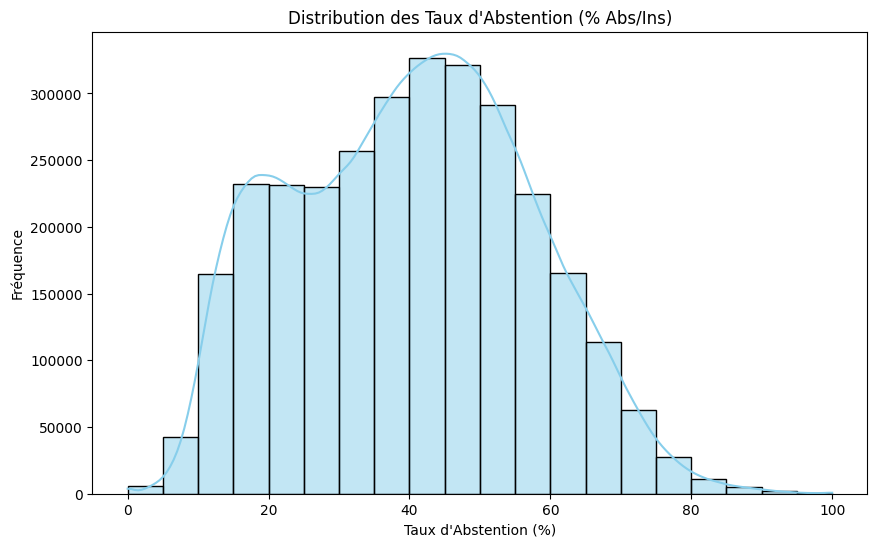

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(df_corrected['% Abs/Ins'], bins=20, kde=True, color='skyblue')
plt.title('Distribution des Taux d\'Abstention (% Abs/Ins)')
plt.xlabel('Taux d\'Abstention (%)')
plt.ylabel('Fréquence')
plt.show()


In [11]:
# Statistiques descriptives de base pour les données d'abstention
abstention_stats = df_corrected[['Abstentions', '% Abs/Ins']].describe()
print(abstention_stats)


        Abstentions     % Abs/Ins
count  3.012498e+06  3.012491e+06
mean   2.903191e+02  4.017340e+01
std    1.168417e+03  1.689426e+01
min    0.000000e+00  0.000000e+00
25%    8.800000e+01  2.665000e+01
50%    2.450000e+02  4.068000e+01
75%    4.400000e+02  5.243000e+01
max    9.710000e+05  1.000000e+02


# Preparation-Données-Abstention-Pauvreté

In [12]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [13]:
import pandas as pd

# Lire le fichier CSV depuis Google Drive
file_path = '/content/drive/MyDrive/Données/Pauvreté/revenus_pauvrete_2017_csv/data_filo17_qp_revdis.csv'

# Lire les données avec pandas
df_pauvrete_2017 = pd.read_csv(file_path,sep=';', low_memory=False)
# Conserver uniquement la colonne "tp60_a17"
df_pauvrete_2017 = df_pauvrete_2017[['codgeo','tp60_a17']]

# Remplacer les virgules par des points dans 'tp60_a17' pour traiter les nombres
df_pauvrete_2017['tp60_a17'] = df_pauvrete_2017['tp60_a17'].str.replace(',', '.').astype(float)

# Extraire les 3 chiffres après 'QP' pour déterminer le département
df_pauvrete_2017['departement'] = df_pauvrete_2017['codgeo'].str.extract(r'^QP(\d{3})')

# Filtrer les lignes où un département est présent
df_pauvrete_2017 = df_pauvrete_2017.dropna(subset=['departement'])

# Calculer la moyenne de pauvreté par département
moyenne_par_departement_2017 = df_pauvrete_2017.groupby('departement')['tp60_a17'].mean().reset_index()

In [14]:
import pandas as pd

# Lire le fichier CSV depuis Google Drive
file_path = '/content/drive/MyDrive/Données/Pauvreté/revenus_pauvrete_2021_qp15_csv/data_indic-revenu-disponible-qp15-2021_QP.csv'

# Lire les données avec pandas
df_pauvrete_2021 = pd.read_csv(file_path,sep=';', low_memory=False)
# Conserver uniquement la colonne "tp60_a17"
df_pauvrete_2021 = df_pauvrete_2021[['CODGEO','DISP_TP60_A21']]

# Remplacer les virgules par des points dans 'tp60_a17' pour traiter les nombres
df_pauvrete_2021['DISP_TP60_A21'] = df_pauvrete_2021['DISP_TP60_A21'].str.replace(',', '.').astype(float)

# Extraire les 3 chiffres après 'QP' pour déterminer le département
df_pauvrete_2021['departement'] = df_pauvrete_2021['CODGEO'].str.extract(r'^QP(\d{3})')

# Filtrer les lignes où un département est présent
df_pauvrete_2021= df_pauvrete_2021.dropna(subset=['departement'])

# Calculer la moyenne de pauvreté par département
moyenne_par_departement_2021 = df_pauvrete_2021.groupby('departement')['DISP_TP60_A21'].mean().reset_index()

In [15]:
# Fusionner les deux DataFrames sur la colonne 'departement'
df_pauvrete = pd.merge(
    moyenne_par_departement_2017,
    moyenne_par_departement_2021,
    on='departement',  # Clé commune
    how='inner'        # Utilise "inner" pour ne garder que les départements communs
)

# Preparation-Données-Abstention-Chomage

In [16]:
import pandas as pd

# Remplacez 'votre_fichier.xlsx' par le chemin de votre fichier
fichier = '/content/drive/MyDrive/Données/Chomage/chomage-zone-t1-2003-t3-2024.xlsx'

# Charger uniquement la feuille 2 du fichier Excel
data = pd.read_excel(fichier, sheet_name=1)  # L'index commence à 0, donc 1 correspond à la feuille 2
# Utiliser la 3ème ligne comme titre des colonnes et supprimer les lignes précédentes
data.columns = data.iloc[4]  # La 3ème ligne devient les noms de colonnes
data = data[5:]  # Supprimer les 3 premières lignes (index 0, 1, 2)
data.reset_index(drop=True, inplace=True)  # Réinitialiser les index
# Filtrer les colonnes à partir de 2017 et regrouper par année
colonnes_taux = [col for col in data.columns if '-' in str(col) and int(col.split('-')[0]) >= 2017]
data_annee = data[colonnes_taux]
data_annee.columns = [col.split('-')[0] for col in colonnes_taux]  # Garder uniquement l'année dans les noms de colonnes

data_moyenne_par_annee = data_annee.astype(float).groupby(by=data_annee.columns, axis=1).mean()

# Ajouter les moyennes annuelles au DataFrame principal
data_chomage = pd.concat([data[['ZE2020', 'LIBZE2020']], data_moyenne_par_annee], axis=1)

# Afficher le DataFrame avec les moyennes annuelles
data_chomage

<ipython-input-16-f3946a0bde9d>:17: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data_moyenne_par_annee = data_annee.astype(float).groupby(by=data_annee.columns, axis=1).mean()


,ZE2020,LIBZE2020,2017,2018,2019,2020,2021,2022,2023,2024
0,0051,Alençon,8.825,8.425,8.050,7.525,7.150,6.650,6.500,6.766667
1,0052,Arles,12.400,11.900,11.150,10.650,10.450,9.750,9.900,9.900000
2,0053,Avignon,11.850,11.525,10.900,10.275,10.225,9.725,9.950,10.100000
3,0054,Beauvais,9.525,9.225,8.475,8.225,8.000,7.550,7.625,7.733333
4,0055,Bollène-Pierrelatte,11.775,11.500,10.650,9.875,9.750,9.225,9.150,9.100000
...,...,...,...,...,...,...,...,...,...,...
297,9403,Calvi,10.350,10.475,9.600,10.125,8.275,7.600,8.000,7.633333
298,9404,Corte,8.950,8.500,7.425,6.750,5.975,5.650,6.025,6.233333
299,9405,Ghisonaccia,10.900,10.500,9.725,8.750,7.900,7.525,7.925,8.300000
300,9406,Porto-Vecchio,12.675,11.600,10.325,11.075,8.750,7.250,7.875,8.500000


In [17]:
import pandas as pd

fichier = '/content/drive/MyDrive/Données/Chomage/fr-esr-referentiel-geographique.csv'

try:
    data = pd.read_csv(fichier, sep=';', on_bad_lines='skip', encoding='utf-8', low_memory=False)
except Exception as e:
    print(f"Erreur lors de la lecture du fichier : {e}")

EZ2020_DEP = data[[ 'ZE_ID','DEP_CODE','DEP_NOM']]

In [18]:
# Supprimer "ZE" du contenu de la colonne `ZE_ID`
EZ2020_DEP['ZE_ID'] = EZ2020_DEP['ZE_ID'].str.replace('^ZE', '', regex=True)

# Afficher le DataFrame modifié
EZ2020_DEP

<ipython-input-18-27c397b55e18>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EZ2020_DEP['ZE_ID'] = EZ2020_DEP['ZE_ID'].str.replace('^ZE', '', regex=True)


,ZE_ID,DEP_CODE,DEP_NOM
0,SO,50,Manche
1,2806,50,Manche
2,SO,50,Manche
3,2805,50,Manche
4,2805,50,Manche
...,...,...,...
38911,SO,987,Polynésie Française
38912,SO,988,Nouvelle-Calédonie
38913,SO,988,Nouvelle-Calédonie
38914,SO,988,Nouvelle-Calédonie


In [19]:
# Renommer la colonne dans df2 pour correspondre à df1
EZ2020_DEP.rename(columns={'ZE_ID': 'ZE2020'}, inplace=True)

# Effectuer la jointure sur la colonne 'ZE2020'
merged_df = pd.merge(data_chomage, EZ2020_DEP, on='ZE2020', how='inner')

# Afficher le DataFrame fusionné
merged_df

<ipython-input-19-7372f4e8a397>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EZ2020_DEP.rename(columns={'ZE_ID': 'ZE2020'}, inplace=True)


,ZE2020,LIBZE2020,2017,2018,2019,2020,2021,2022,2023,2024,DEP_CODE,DEP_NOM
0,0051,Alençon,8.825,8.425,8.050,7.525,7.15,6.65,6.500,6.766667,53,Mayenne
1,0051,Alençon,8.825,8.425,8.050,7.525,7.15,6.65,6.500,6.766667,53,Mayenne
2,0051,Alençon,8.825,8.425,8.050,7.525,7.15,6.65,6.500,6.766667,53,Mayenne
3,0051,Alençon,8.825,8.425,8.050,7.525,7.15,6.65,6.500,6.766667,61,Orne
4,0051,Alençon,8.825,8.425,8.050,7.525,7.15,6.65,6.500,6.766667,61,Orne
...,...,...,...,...,...,...,...,...,...,...,...,...
34946,9407,Propriano,11.600,10.250,9.375,9.475,7.75,6.95,7.375,7.466667,2A,Corse-du-Sud
34947,9407,Propriano,11.600,10.250,9.375,9.475,7.75,6.95,7.375,7.466667,2A,Corse-du-Sud
34948,9407,Propriano,11.600,10.250,9.375,9.475,7.75,6.95,7.375,7.466667,2A,Corse-du-Sud
34949,9407,Propriano,11.600,10.250,9.375,9.475,7.75,6.95,7.375,7.466667,2A,Corse-du-Sud


In [20]:
# Calculer le taux de chômage moyen par département pour chaque année
grouped = merged_df.groupby(['DEP_CODE','DEP_NOM'])[['2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']].mean()

# Réinitialiser l'index pour obtenir un DataFrame propre
result = grouped.reset_index()

# Afficher le résultat
result

,DEP_CODE,DEP_NOM,2017,2018,2019,2020,2021,2022,2023,2024
0,01,Ain,7.293495,6.887117,6.582270,6.481441,6.284758,5.784120,5.797577,5.948724
1,02,Aisne,12.270927,11.720363,10.961591,10.301378,10.324687,9.783741,9.898778,9.909816
2,03,Allier,9.460252,9.182256,8.720741,8.261672,7.947871,7.461199,7.558675,7.731756
3,04,Alpes-de-Haute-Provence,10.524874,10.201136,9.540278,8.924116,8.817424,8.254924,8.197601,8.146128
4,05,Hautes-Alpes,8.617593,8.334259,7.822222,7.611111,7.827778,6.736111,6.539815,6.325926
...,...,...,...,...,...,...,...,...,...,...
94,94,Val-de-Marne,8.350000,8.075000,7.525000,7.425000,7.550000,6.875000,6.850000,6.933333
95,95,Val-d'Oise,8.978668,8.703125,8.127853,8.101223,8.350951,7.767663,7.743071,7.820833
96,971,Guadeloupe,22.625781,23.082812,21.174219,17.667969,17.542188,19.041406,19.003125,17.467708
97,972,Martinique,18.419853,17.933088,15.586029,12.823529,13.365441,12.942647,11.160294,12.239216


In [21]:
result.to_csv('taux_chomage_par_departement.csv', index=False)


# Preparation-Données-Abstention-Age

In [22]:
df_menages_communes = pd.read_csv('/content/drive/MyDrive/Données/Age/agesexdepartements.csv', sep=",", encoding="utf-8")
df_menages_communes.head()

dep                   nomdep  popf1851  popf1852  popf1853  popf1854  \
0  01                      AIN    183106    182908    182709    182511   
1  02                    AISNE    282996    282647    282297    281948   
2  03                   ALLIER    166379    167909    169439    170969   
3  04  ALPES-DE-HAUTE-PROVENCE     73351     73119     72888     72656   
4  05             HAUTES-ALPES     63609     63370     63131     62891   

   popf1855  popf1856  popf1857  popf1858  popf1859  popf1860  popf1861  \
0    182312    182114    182381    182648    182915    183182    183449   
1    281598    281249    281638    282027    282416    282805    283195   
2    172499    174029    175282    176536    177789    179042    180296   
3     72425     72193     71814     71435     71056     70677     70298   
4     62652     62413     62183     61953     61723     61493     61264   

   popf1862  popf1863  popf1864  popf1865  popf1866  popf1867  popf1868  \
0    183716    183983    184250    184517    184784    183971    183157   
1    283584    283973    284362    284751    285140    284753    284365   
2    181549    182802    184055    185309    186562    188066    189570   
3     69918     69539     69160     68781     68402     68105     67809   
4     61034     60804     60574     60344     60114     59871     59628   

   popf1869  popf1870  popf1871  popf1872  popf1873  popf1874  popf1875  \
0    182344    181530    180717    179903    179090    178276    177463   
1    283978    283591    283204    282816    282429    282042    281654   
2    191073    192577    194081    195585    197089    198592    200096   
3     67512     67215     66919     66622     66325     66028     65732   
4     59384     59141     58898     58655     58412     58168     57925   

   popf1876  popf1877  popf1878  popf1879  popf1880  popf1881  popf1882  \
0    176649    176574    176500    176425    176350    176276    176201   
1    281267    281426    281586    281745    281904    282064    282223   
2    201600    202716    203832    204949    206065    207181    208297   
3     65435     65050     64666     64281     63897     63512     63127   
4     57682     57687     57691     57696     57700     57705     57709   

   popf1883  popf1884  popf1885  popf1886  popf1887  popf1888  popf1889  \
0    176126    176051    175977    175902    175366    174831    174295   
1    282382    282541    282701    282860    282015    281170    280325   
2    209413    210530    211646    212762    212741    212719    212698   
3     62743     62358     61974     61589     60987     60384     59782   
4     57714     57718     57723     57727     57306     56885     56464   

   popf1890  popf1891  popf1892  popf1893  popf1894  popf1895  popf1896  \
0    173759    173224    172688    172152    171616    171081    170545   
1    279480    278636    277791    276946    276101    275256    274411   
2    212676    212655    212634    212612    212591    212569    212548   
3     59179     58577     57975     57372     56770     56167     55565   
4     56043     55622     55201     54780     54359     53938     53517   

   popf1897  popf1898  popf1899  popf1900  popf1901  popf1902  popf1903  \
0    170564    170583    170601    170620    170639    170215    169791   
1    273895    273378    272862    272345    271829    271950    272071   
2    212728    212908    213089    213269    213449    213010    212571   
3     55301     55037     54774     54510     54246     54043     53839   
4     53239     52960     52682     52403     52125     51880     51634   

   popf1904  popf1905  popf1906  popf1907  popf1908  popf1909  popf1910  \
0    169367    168943    168519    168175    167831    167487    167143   
1    272192    272313    272434    271984    271534    271085    270635   
2    212132    211693    211254    210197    209140    208084    207027   
3     53636     53432     53229     52838     52447     52056     51665   
4     51389     51143    

In [23]:
# Conserver les 2 premières colonnes
colonnes_debut = df_menages_communes.iloc[:, :2]

# Conserver les 70 dernières colonnes
colonnes_fin = df_menages_communes.iloc[:, -60:]

# Combiner les deux ensembles
df = pd.concat([colonnes_debut, colonnes_fin], axis=1)

# Afficher le DataFrame résultant
df

,dep,nomdep,pop2017,propf2017,propf0142017,propf15392017,propf40592017,propf60p2017,prop0142017,prop15392017,prop40592017,prop60p2017,pop2018,propf2018,propf0142018,propf15392018,propf40592018,propf60p2018,prop0142018,prop15392018,prop40592018,prop60p2018,pop2019,propf2019,propf0142019,propf15392019,propf40592019,propf60p2019,prop0142019,prop15392019,prop40592019,prop60p2019,pop2020,propf2020,propf0142020,propf15392020,propf40592020,propf60p2020,prop0142020,prop15392020,prop40592020,prop60p2020,pop2021,propf2021,propf0142021,propf15392021,propf40592021,propf60p2021,prop0142021,prop15392021,prop40592021,prop60p2021,pop2022,propf2022,propf0142022,propf15392022,propf40592022,propf60p2022,prop0142022,prop15392022,prop40592022,prop60p2022
0,01,AIN,646053,0.506657,0.488811,0.494783,0.501227,0.543628,0.199409,0.290628,0.279353,0.230610,653707,0.506797,0.488307,0.495314,0.501568,0.542932,0.198456,0.288443,0.279445,0.233657,661451,0.506890,0.487615,0.495926,0.501896,0.542153,0.197561,0.286314,0.279523,0.236601,669238,0.507054,0.487177,0.496480,0.502266,0.541525,0.196760,0.284190,0.279575,0.239475,677151,0.507194,0.486823,0.497066,0.502540,0.540844,0.196015,0.282122,0.279613,0.242250,685222,0.507310,0.486327,0.497601,0.502847,0.540233,0.195267,0.280106,0.279654,0.244973
1,02,AISNE,535317,0.512087,0.486955,0.495995,0.502906,0.556450,0.189308,0.281058,0.265491,0.264143,535096,0.511800,0.486864,0.495514,0.502795,0.554861,0.188286,0.278464,0.263745,0.269505,535217,0.511303,0.486494,0.494739,0.502576,0.553183,0.187442,0.275952,0.261860,0.274747,535806,0.510786,0.486043,0.493761,0.502426,0.551699,0.186745,0.273412,0.260012,0.279831,536769,0.510236,0.485890,0.492820,0.502032,0.550150,0.186162,0.270902,0.258117,0.284819,538165,0.509767,0.485897,0.491876,0.501770,0.548720,0.185707,0.268425,0.256178,0.289690
2,03,ALLIER,338589,0.522539,0.489959,0.496264,0.513674,0.562351,0.152368,0.238720,0.267179,0.341733,338133,0.522516,0.488688,0.496052,0.515319,0.560853,0.151772,0.236324,0.265073,0.346831,337830,0.522526,0.487331,0.495983,0.517181,0.559305,0.151292,0.233961,0.262913,0.351834,337651,0.522575,0.486026,0.495922,0.519151,0.557830,0.150798,0.231671,0.260731,0.356800,337650,0.522594,0.484814,0.495694,0.521111,0.556440,0.150461,0.229382,0.258558,0.361599,337854,0.522587,0.483655,0.495466,0.523030,0.555061,0.150216,0.227157,0.256333,0.366294
3,04,ALPES-DE-HAUTE-PROVENCE,163249,0.513100,0.480902,0.495091,0.513216,0.541970,0.158929,0.242072,0.271849,0.327151,163833,0.512742,0.481603,0.494172,0.513408,0.540503,0.157764,0.240361,0.270635,0.331240,164476,0.512482,0.482309,0.493666,0.513484,0.539164,0.156716,0.238545,0.269419,0.335319,165268,0.512319,0.482993,0.493080,0.514018,0.537880,0.155656,0.236961,0.268261,0.339122,166123,0.512151,0.483600,0.492687,0.514458,0.536607,0.154711,0.235428,0.267085,0.342776,167076,0.511857,0.483704,0.492477,0.514631,0.535328,0.153894,0.233906,0.265903,0.346297
4,05,HAUTES-ALPES,142073,0.509323,0.476622,0.489588,0.505631,0.547036,0.167703,0.253173,0.274373,0.304752,143087,0.508746,0.472579,0.488704,0.506044,0.546772,0.166682,0.250875,0.272317,0.310126,144162,0.508234,0.468686,0.487729,0.506543,0.546622,0.165585,0.248720,0.270349,0.315347,145322,0.507645,0.465124,0.486602,0.506742,0.546474,0.164751,0.246528,0.268452,0.320268,146578,0.506966,0.461337,0.485567,0.506461,0.546498,0.164015,0.244375,0.266623,0.324987,147898,0.506295,0.458073,0.484458,0.506152,0.546363,0.163281,0.242316,0.264885,0.329518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,91,ESSONNE,1300343,0.511224,0.494243,0.502488,0.502259,0.555517,0.209069,0.324741,0.267792,0.198398,1312885,0.511404,0.494734,0.503045,0.501277,0.555801,0.209215,0.323162,0.267269,0.200354,1325464,0.511574,0.495171,0.503605,0.500329,0.556051,0.209370,0.321594,0.266759,0.202278,1338

In [24]:
# Colonnes contenant les données de 2017 et 2022 uniquement
columns_2017_2022 = [col for col in df.columns if '2017' in col or '2022' in col]

# Ajouter également les colonnes de base pour identifier les départements
base_columns = ['dep', 'nomdep']

# Sélectionner les colonnes finales
selected_columns = base_columns + columns_2017_2022

# Filtrer le DataFrame
df_2017_2022 = df[selected_columns]

# Afficher les premières lignes pour vérification
df_2017_2022.head()

,dep,nomdep,pop2017,propf2017,propf0142017,propf15392017,propf40592017,propf60p2017,prop0142017,prop15392017,prop40592017,prop60p2017,pop2022,propf2022,propf0142022,propf15392022,propf40592022,propf60p2022,prop0142022,prop15392022,prop40592022,prop60p2022
0,01,AIN,646053,0.506657,0.488811,0.494783,0.501227,0.543628,0.199409,0.290628,0.279353,0.230610,685222,0.507310,0.486327,0.497601,0.502847,0.540233,0.195267,0.280106,0.279654,0.244973
1,02,AISNE,535317,0.512087,0.486955,0.495995,0.502906,0.556450,0.189308,0.281058,0.265491,0.264143,538165,0.509767,0.485897,0.491876,0.501770,0.548720,0.185707,0.268425,0.256178,0.289690
2,03,ALLIER,338589,0.522539,0.489959,0.496264,0.513674,0.562351,0.152368,0.238720,0.267179,0.341733,337854,0.522587,0.483655,0.495466,0.523030,0.555061,0.150216,0.227157,0.256333,0.366294
3,04,ALPES-DE-HAUTE-PROVENCE,163249,0.513100,0.480902,0.495091,0.513216,0.541970,0.158929,0.242072,0.271849,0.327151,167076,0.511857,0.483704,0.492477,0.514631,0.535328,0.153894,0.233906,0.265903,0.346297
4,05,HAUTES-ALPES,142073,0.509323,0.476622,0.489588,0.505631,0.547036,0.167703,0.253173,0.274373,0.304752,147898,0.506295,0.458073,0.484458,0.506152,0.546363,0.163281,0.242316,0.264885,0.329518


In [25]:
df_2017_2022.to_csv('age_2017_2022.csv', index=False, encoding='utf-8')